<a href="https://colab.research.google.com/github/its-rajesh/Music-Speech-Separation/blob/main/MSClassifierV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MUSIC SPEECH CONV NEURAL NETWORK CLASSIFIER**

### **Imports**

In [16]:
import tensorflow as tf
from tensorflow import keras

In [17]:
import soundfile as sf
import librosa as lb
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd

### **Reading audio files and creating chunks**

In [3]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [4]:
'''
THIS FUNCTION ACCEPTS FOLDER PATH WHICH CONTAINS SPEECH AND MUSIC DATASET
RETURNS: 1D ARRAY OF AUDIO FILES
'''
def readaudiofiles(path):

  folders = os.listdir(path)
  print(folders)

  audiofiles = []
  for folder in folders:
    files = os.listdir(path+'/'+folder)
    files = sorted(files)
    audio = []
    for file in files:
        data, samplerate = lb.load(path+'/'+folder+'/'+file, sr=8000, mono=True)
        audio.append(data)
    audiofiles.append(audio)

  music = np.array(audiofiles[3])
  mixture = np.array(audiofiles[0])
  overlay = np.array(audiofiles[1])
  speech = np.array(audiofiles[2])

  dataset = [music, mixture, overlay, speech]
  print(samplerate)

  return music, mixture, overlay, speech, dataset


path = '/drive/My Drive/Projects/Music-Speech-Separation/Dataset/'
music, mixture, overlay, speech, dataset = readaudiofiles(path)

['Mixture', 'Overlay', 'speech', 'music']
8000


In [5]:
music[0], len(music[0]), len(music[0])/8000

(array([-0.06211764, -0.17527802, -0.13408872, ...,  0.06697536,
         0.07972796,  0.11764227], dtype=float32), 120000, 15.0)

In [6]:
'''
THIS FUNCTION CREATES CHUNCKS OF THE GIVEN AUDIO FILE
INPUTS: AUDIO (Can change the chunks length in seconds as indicated)
RETURNS: CHUNCKS
'''
def createchunks(audio):
  start = 0
  stop = 4000 # for 0.5 seconds (8Khz): 1 sec has 8000 samples.
  chunks = []
  for i in range(len(audio)//4000):
    chunks.append(audio[start:stop])
    start = stop
    stop = start+4000

  return chunks

### **Obtaining STFT features**

In [ ]:
def stft_extract(music, speech):
  datasetstft = []
  index = 0
  y_train = []
  for data in [music, speech]:
      spect = []
      y = []
      for audio in data:
        chunks = np.array(createchunks(audio))
        chunks_spect = []
        for i in chunks:
          chunks_spect.append(np.abs(lb.stft(i,n_fft=512))) #window length = nfft and hop length = win length //4

        chunks_spect = np.array(chunks_spect)

        spect.append(chunks_spect)

        if index == 0:
          y.append(np.zeros(30))
        elif index == 1:
          y.append(np.ones(30))
      
      index += 1
      y_train.append(np.array(y))
      datasetstft.append(np.array(spect))

  return datasetstft, y_train

In [ ]:
datasetstft, y_train_stft = stft_extract(music, speech)

In [ ]:
y_train_stft[0].shape, len(y_train_stft)

((50, 30), 2)

In [ ]:
datasetstft[0].shape, len(datasetstft)

((50, 30, 257, 32), 2)

### **Obtaining chroma features**

In [52]:
def chroma_extract(music, speech):
  datasetchroma = []
  index = 0
  y_train = []
  for data in [music, speech]:
      spect = []
      y = []
      for audio in data:
        chunks = np.array(createchunks(audio))
        chunks_spect = []
        for i in chunks:
          chunks_spect.append(lb.feature.chroma_stft(y=i))

        chunks_spect = np.array(chunks_spect)

        spect.append(chunks_spect)

        if index == 0:
          y.append(np.zeros(30))
        elif index == 1:
          y.append(np.ones(30))
      
      index += 1
      y_train.append(np.array(y))
      datasetchroma.append(np.array(spect))

  return datasetchroma, y_train

In [53]:
datasetchroma, y_train_chroma = chroma_extract(music, speech)

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [54]:
y_train_chroma[0].shape, len(y_train_chroma)

((50, 30), 2)

In [55]:
datasetchroma[0].shape, len(datasetchroma)

((50, 30, 12, 8), 2)

### **Reshaping the training datasets**

In [56]:
def reshape_dataset(trainD):
  X_TRAIN = []
  for data in trainD:
    for i in data:
      for j in i:
        X_TRAIN.append(j)

  return np.array(X_TRAIN)

In [57]:
def reshape_y(y_train):
  Y_TRAIN = []
  for val in y_train:
    for i in val:
      for j in i:
        Y_TRAIN.append(j)

  return np.array(Y_TRAIN)

**STFT FEATURES AS TRAINING**

In [ ]:
X_TRAIN = reshape_dataset(datasetstft)
Y_TRAIN = reshape_y(y_train_stft)

X_TRAIN.shape, Y_TRAIN.shape

((3000, 257, 32), (3000,))

**CHROMA FEATURES AS TRAINING**

In [58]:
X_TRAIN = reshape_dataset(datasetchroma)
Y_TRAIN = reshape_y(y_train_chroma)

X_TRAIN.shape, Y_TRAIN.shape

((3000, 12, 8), (3000,))

### **Test data preparation**

In [18]:
'''
THIS FUNCTION ACCEPTS FOLDER PATH WHICH CONTAINS SPEECH AND MUSIC DATASET
RETURNS: 1D ARRAY OF AUDIO FILES
'''
def readaudiofiles(path):

  folders = os.listdir(path)
  print(folders)

  audiofiles = []
  for folder in folders:
    files = os.listdir(path+'/'+folder)
    files = sorted(files)
    audio = []
    for file in files:
        data, samplerate = lb.load(path+'/'+folder+'/'+file, sr=8000, mono=True)
        audio.append(data)
    audiofiles.append(audio)

  music = np.array(audiofiles[1])
  mixture = np.array(audiofiles[2])
  overlay = np.array(audiofiles[3])
  speech = np.array(audiofiles[0])

  dataset = [music, mixture, overlay, speech]
  print(samplerate)

  return music, mixture, overlay, speech, dataset

In [19]:
test_path = '/drive/My Drive/Projects/Music-Speech-Separation/Test Dataset/'

music_test, mixture_test, overlay_test, speech_test, dataset_test = readaudiofiles(test_path)

print(music_test[0], len(music_test[0]), len(music_test[0])/8000)

['speech', 'music', 'mixture', 'overlay']
8000
[-0.06551269 -0.09722305 -0.09252059 ... -0.0058487   0.04005643
  0.08765063] 120000 15.0


In [20]:
dataset_test_stft, y_test_stft = stft_extract(music_test, speech_test)
print(dataset_test_stft[0].shape, len(dataset_test_stft))

In [59]:
dataset_test_chroma, y_test_chroma = chroma_extract(music_test, speech_test)
print(dataset_test_chroma[0].shape, len(dataset_test_chroma))

/usr/local/lib/python3.7/dist-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


(10, 30, 12, 8) 2


**TEST STFT FEATURES**

In [ ]:
X_TEST = reshape_dataset(dataset_test_stft)
Y_TEST = reshape_y(y_test_stft)

X_TEST.shape, Y_TEST.shape

((600, 257, 32), (600,))

**TEST CHROMA FEATURES**

In [66]:
X_TEST = reshape_dataset(dataset_test_chroma)
Y_TEST = reshape_y(y_test_chroma)

X_TEST.shape, Y_TEST.shape

((600, 12, 8), (600,))

# **CNN MODEL**

In [24]:
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Conv2D,MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [60]:
batch_size = 32
epochs = 50
inp = Input(shape =(12, 8, 1))
out_dim = 2

In [62]:
start = time.time()

x = Conv2D(32, 3, activation='relu')(inp)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.10)(x)

x = Conv2D(64, 3, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(1, 1))(x)
x = Dropout(0.10)(x)

x = Flatten()(x)
x = Dense(100, activation='relu')(x)
x = Dropout(0.10)(x)

x = Dense(out_dim, activation='softmax')(x)

In [63]:
x_train = X_TRAIN
y_train = Y_TRAIN

In [64]:
classify = Model(inputs = inp, outputs = x)
classify.compile(loss='SparseCategoricalCrossentropy', optimizer = 'adam', metrics='accuracy') 
#classify.summary()
classify_train = classify.fit(x_train,y_train, epochs = epochs ,batch_size=batch_size)
end = time.time()
print("time taken",time)

Epoch 1/50
94/94 [==============================] - 2s 11ms/step - loss: 0.7007 - accuracy: 0.7267
Epoch 2/50
94/94 [==============================] - 1s 11ms/step - loss: 0.3742 - accuracy: 0.8483
Epoch 3/50
94/94 [==============================] - 1s 12ms/step - loss: 0.2702 - accuracy: 0.8860
Epoch 4/50
94/94 [==============================] - 1s 12ms/step - loss: 0.2072 - accuracy: 0.9140
Epoch 5/50
94/94 [==============================] - 1s 11ms/step - loss: 0.1802 - accuracy: 0.9300
Epoch 6/50
94/94 [==============================] - 1s 11ms/step - loss: 0.1484 - accuracy: 0.9413
Epoch 7/50
94/94 [==============================] - 1s 11ms/step - loss: 0.1300 - accuracy: 0.9513
Epoch 8/50
94/94 [==============================] - 1s 12ms/step - loss: 0.0979 - accuracy: 0.9647
Epoch 9/50
94/94 [==============================] - 1s 12ms/step - loss: 0.0854 - accuracy: 0.9673
Epoch 10/50
94/94 [==============================] - 1s 11ms/step - loss: 0.0815 - accuracy: 0.9713
Epoch 11/

In [67]:
test_eval = classify.evaluate(X_TEST,  Y_TEST, verbose=0)
print('Test', test_eval)

Test [1.1929415464401245, 0.8216666579246521]


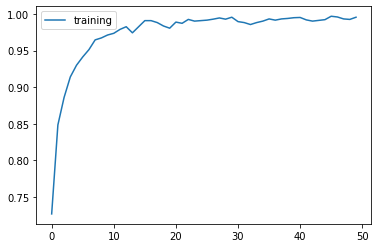

In [68]:
plt.plot(classify_train.history['accuracy'])
plt.legend(['training'], loc = 'upper left')
plt.show()

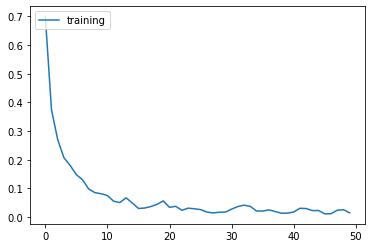

In [69]:
plt.plot(classify_train.history['loss'])
plt.legend(['training'], loc = 'upper left')
plt.show()

In [70]:
predictions = classify.predict(X_TEST, verbose=1)
result = np.argmax(predictions, axis=1)
result

19/19 [==============================] - 0s 4ms/step


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,

In [71]:
cm = tf.math.confusion_matrix(Y_TEST, result)
cm

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[239,  61],
       [ 46, 254]], dtype=int32)>

# **TEST ON AIR DATA**

In [72]:
sample_audio, sr  = lb.load('/drive/My Drive/Projects/Music-Speech-Separation/kannada.wav', sr=8000, mono=True)
sample_audio, sr, len(sample_audio), len(sample_audio)/8000

(array([0.        , 0.        , 0.        , ..., 0.11099157, 0.09802414,
        0.        ], dtype=float32), 8000, 2519458, 314.93225)

In [73]:
chunks_sample = np.array(createchunks(sample_audio))
print(chunks_sample.shape)
spect_sample = []
for i in chunks_sample:
  spect_sample.append(lb.feature.chroma_stft(y=i))

spect_sample = np.array(spect_sample)
spect_sample.shape

(629, 4000)


(629, 12, 8)

In [74]:
res = classify.predict(spect_sample)
res = np.argmax(res, axis=1)
res

array([1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [75]:
len(res)

629

### **DELETING MUSIC FROM SPEECH**

In [76]:
seconds = 0
time_split = []
for i in range(len(res)):
  seconds += 0.5
  if res[i] == 1:
    time_split.append(seconds)

print(time_split)

[0.5, 3.0, 3.5, 5.0, 5.5, 6.0, 7.0, 7.5, 8.5, 9.5, 12.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0, 19.0, 19.5, 20.0, 20.5, 21.5, 22.0, 22.5, 23.0, 24.0, 24.5, 25.0, 26.0, 27.0, 27.5, 28.0, 28.5, 29.5, 30.0, 30.5, 31.0, 32.0, 33.0, 33.5, 34.0, 34.5, 36.0, 36.5, 37.0, 37.5, 38.0, 38.5, 39.0, 39.5, 40.5, 41.0, 42.0, 42.5, 43.0, 43.5, 44.0, 45.0, 45.5, 46.0, 46.5, 48.0, 48.5, 49.0, 50.5, 51.0, 51.5, 52.0, 52.5, 53.0, 54.0, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5, 58.0, 58.5, 59.5, 60.5, 61.0, 61.5, 62.0, 62.5, 63.0, 63.5, 64.0, 64.5, 65.0, 65.5, 66.0, 66.5, 67.0, 67.5, 68.0, 68.5, 69.5, 70.0, 70.5, 71.0, 71.5, 72.0, 72.5, 73.0, 73.5, 74.0, 74.5, 75.0, 75.5, 76.5, 77.0, 77.5, 78.5, 79.0, 79.5, 80.0, 80.5, 81.5, 82.0, 82.5, 83.0, 83.5, 84.0, 84.5, 85.0, 85.5, 86.0, 86.5, 87.0, 87.5, 88.0, 89.0, 89.5, 90.0, 90.5, 91.0, 91.5, 92.0, 92.5, 93.0, 93.5, 94.0, 94.5, 95.0, 95.5, 96.0, 96.5, 97.0, 97.5, 98.0, 98.5, 99.0, 99.5, 100.0, 100.5, 101.0, 101.5, 102.0, 102.5, 103.0, 103.5, 104.0

In [78]:
time_index = []
time_index.append(time_split[0])
for i in range(len(time_split)-1):
  if time_split[i+1] != time_split[i]+0.5:
    time_index.append(time_split[i])
    time_index.append(time_split[i+1])

time_index.append(time_split[-1])
np.array(time_index)

array([  0.5,   0.5,   3. ,   3.5,   5. ,   6. ,   7. ,   7.5,   8.5,
         8.5,   9.5,   9.5,  12. ,  12. ,  13.5,  18. ,  19. ,  20.5,
        21.5,  23. ,  24. ,  25. ,  26. ,  26. ,  27. ,  28.5,  29.5,
        31. ,  32. ,  32. ,  33. ,  34.5,  36. ,  39.5,  40.5,  41. ,
        42. ,  44. ,  45. ,  46.5,  48. ,  49. ,  50.5,  53. ,  54. ,
        54. ,  55. ,  58.5,  59.5,  59.5,  60.5,  68.5,  69.5,  75.5,
        76.5,  77.5,  78.5,  80.5,  81.5,  88. ,  89. , 104.5, 105.5,
       107. , 109. , 116. , 117. , 123. , 124. , 134.5, 135.5, 139.5,
       141. , 150.5, 151.5, 153. , 154. , 154. , 155. , 155.5, 156.5,
       156.5, 157.5, 161.5, 162.5, 167.5, 169. , 172. , 173. , 173.5,
       174.5, 175. , 176. , 178.5, 179.5, 181.5, 182.5, 185.5, 186.5,
       194. , 195. , 206.5, 208.5, 211.5, 212.5, 213. , 214. , 217. ,
       218. , 221. , 222.5, 233.5, 234.5, 234.5, 235.5, 241. , 242. ,
       244. , 245.5, 252.5, 253.5, 256. , 257. , 263. , 264. , 264.5,
       266. , 267.5,

In [79]:
time_tuple = []
for i in range(0, len(time_index)-1, 2):
  if time_index[i] != 0 and time_index[i] != 0.5:
    time_tuple.append(((time_index[i])*1000, (time_index[i+1])*1000)) #converting into msec
  else:
    time_tuple.append(((time_index[i])*1000, (time_index[i+1])*1000))

time_tuple

[(500.0, 500.0),
 (3000.0, 3500.0),
 (5000.0, 6000.0),
 (7000.0, 7500.0),
 (8500.0, 8500.0),
 (9500.0, 9500.0),
 (12000.0, 12000.0),
 (13500.0, 18000.0),
 (19000.0, 20500.0),
 (21500.0, 23000.0),
 (24000.0, 25000.0),
 (26000.0, 26000.0),
 (27000.0, 28500.0),
 (29500.0, 31000.0),
 (32000.0, 32000.0),
 (33000.0, 34500.0),
 (36000.0, 39500.0),
 (40500.0, 41000.0),
 (42000.0, 44000.0),
 (45000.0, 46500.0),
 (48000.0, 49000.0),
 (50500.0, 53000.0),
 (54000.0, 54000.0),
 (55000.0, 58500.0),
 (59500.0, 59500.0),
 (60500.0, 68500.0),
 (69500.0, 75500.0),
 (76500.0, 77500.0),
 (78500.0, 80500.0),
 (81500.0, 88000.0),
 (89000.0, 104500.0),
 (105500.0, 107000.0),
 (109000.0, 116000.0),
 (117000.0, 123000.0),
 (124000.0, 134500.0),
 (135500.0, 139500.0),
 (141000.0, 150500.0),
 (151500.0, 153000.0),
 (154000.0, 154000.0),
 (155000.0, 155500.0),
 (156500.0, 156500.0),
 (157500.0, 161500.0),
 (162500.0, 167500.0),
 (169000.0, 172000.0),
 (173000.0, 173500.0),
 (174500.0, 175000.0),
 (176000.0, 17850